## Importing

In [33]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os
from tqdm import tqdm


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Datasets Preparation (Training)

In [34]:
def datasets_preparation ():

     # Dataset and date    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')

     ds_prod_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_prod_T.nc')

     ds = xr.open_dataset (ds_name)
     ds_bio = xr.open_dataset (ds_bio_name)
     ds_prod = xr.open_dataset(ds_prod_name)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     diat_i = (ds_prod.PPDIAT.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
     # flag_i = (ds_prod.PPPHY.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
     #           [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

     return (temp_i1, temp_i2, saline_i1, saline_i2, diat_i)


## Regressor

In [35]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    extra_tree = ExtraTreeRegressor(criterion='poisson')
    regr = BaggingRegressor(extra_tree, n_estimators=10, max_features=4).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),4)
    

    return (r, rms, m, regr)

# Printing

In [36]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [37]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [38]:
def plotting (variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.legend(['diatom','flagellate'])
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Regressor 2

In [39]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)

    m = scatter_plot(targets, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = np.round(mse(targets, outputs_test),4)

    return (r, rms, m)

## Training of 2007

Gathering days for year 2007


100%|██████████| 75/75 [02:53<00:00,  2.31s/it]


Done gathering, building the prediction model


The amount of data points is 871482
The slope of the best fitting line is  0.908
The correlation coefficient is: 0.958
 The mean square error is: 0.0


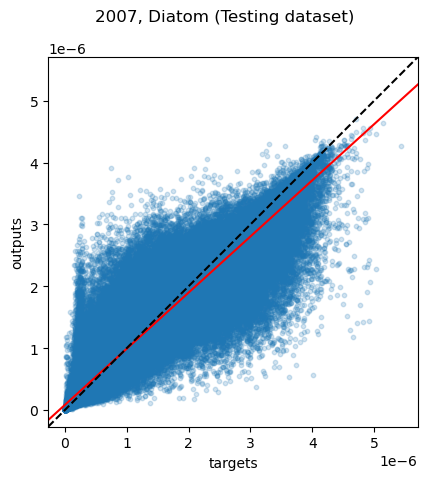

In [40]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

year = 2007

year_str = str(year)[2:4]

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

drivers_all = np.array([[],[],[],[]])
diat_all = np.array([])

print ('Gathering days for year ' + str(year))

for i in tqdm(folders):

    temp_i1, temp_i2, saline_i1, saline_i2, diat_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]
    drivers_all = np.concatenate((drivers_all,drivers),axis=1)

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]
    diat_all = np.concatenate((diat_all,diat))

print ('Done gathering, building the prediction model')
print ('\n')

r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')



## Other Years

Gathering days for year 2007


100%|██████████| 75/75 [02:02<00:00,  1.63s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.951
The correlation coefficient is: 0.984
 The mean square error is: 0.0


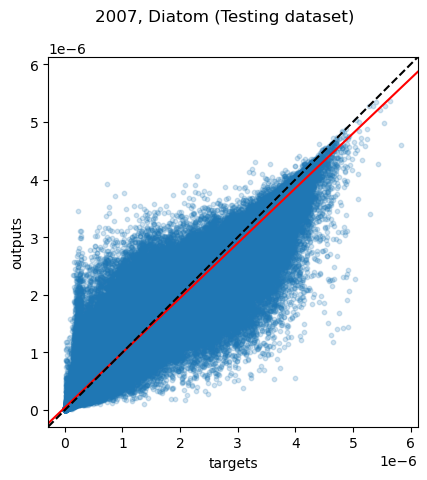

Gathering days for year 2008


100%|██████████| 76/76 [02:52<00:00,  2.28s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.685
The correlation coefficient is: 0.664
 The mean square error is: 0.0


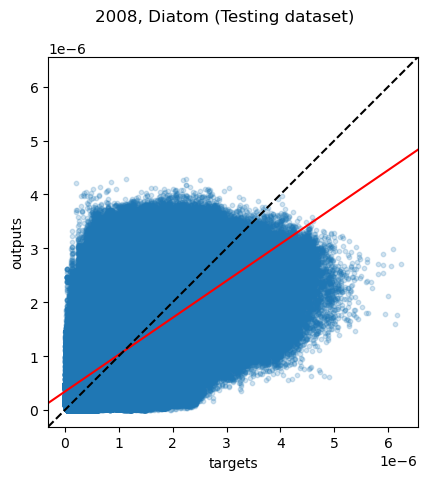

Gathering days for year 2009


100%|██████████| 75/75 [02:56<00:00,  2.36s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.515
The correlation coefficient is: 0.684
 The mean square error is: 0.0


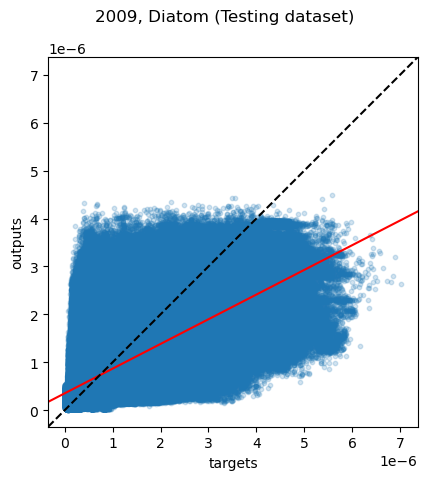

Gathering days for year 2010


100%|██████████| 75/75 [02:55<00:00,  2.34s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.658
The correlation coefficient is: 0.64
 The mean square error is: 0.0


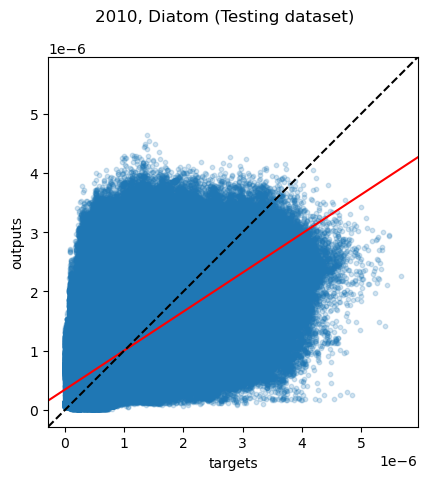

Gathering days for year 2011


100%|██████████| 75/75 [02:54<00:00,  2.33s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.591
The correlation coefficient is: 0.626
 The mean square error is: 0.0


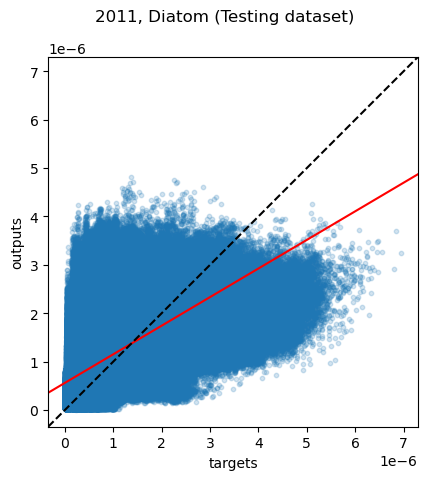

Gathering days for year 2012


100%|██████████| 76/76 [02:56<00:00,  2.32s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.631
The correlation coefficient is: 0.691
 The mean square error is: 0.0


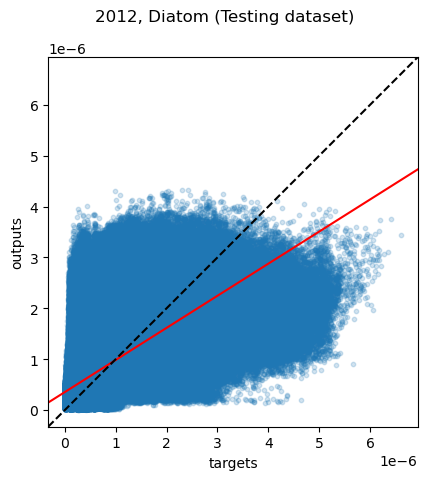

Gathering days for year 2013


100%|██████████| 75/75 [02:55<00:00,  2.34s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.552
The correlation coefficient is: 0.642
 The mean square error is: 0.0


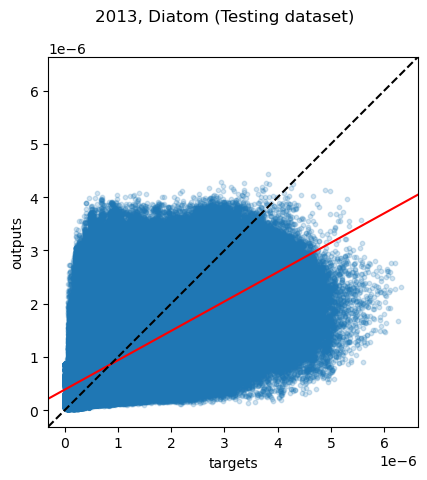

Gathering days for year 2014


100%|██████████| 75/75 [02:55<00:00,  2.34s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.61
The correlation coefficient is: 0.611
 The mean square error is: 0.0


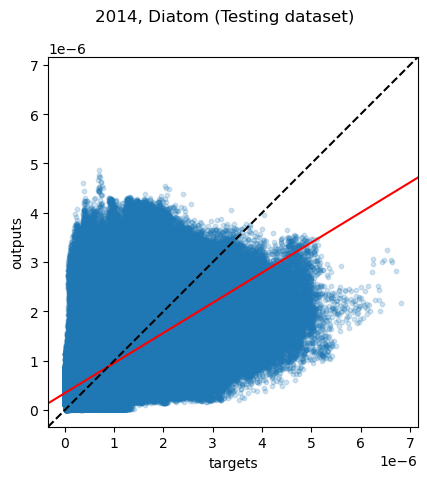

Gathering days for year 2015


100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.383
The correlation coefficient is: 0.358
 The mean square error is: 0.0


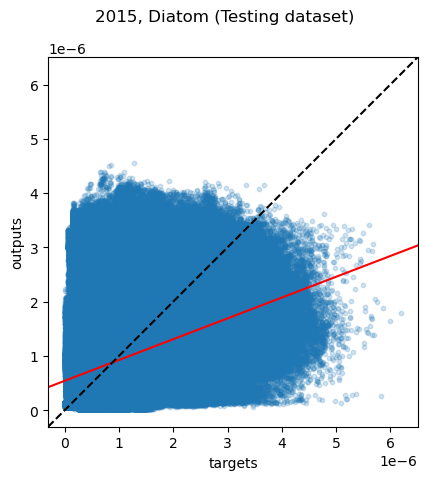

Gathering days for year 2016


100%|██████████| 76/76 [02:55<00:00,  2.31s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.442
The correlation coefficient is: 0.528
 The mean square error is: 0.0


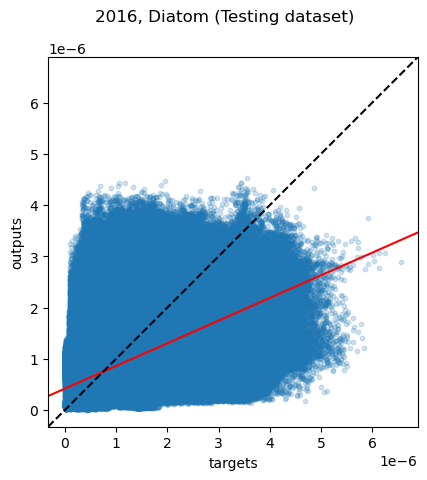

Gathering days for year 2017


100%|██████████| 75/75 [02:59<00:00,  2.39s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.744
The correlation coefficient is: 0.667
 The mean square error is: 0.0


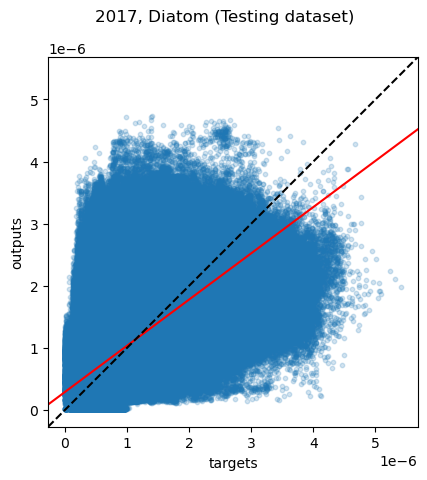

Gathering days for year 2018


100%|██████████| 75/75 [03:00<00:00,  2.41s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.387
The correlation coefficient is: 0.377
 The mean square error is: 0.0


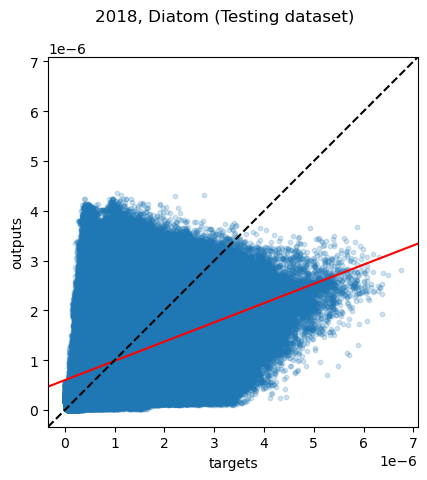

Gathering days for year 2019


100%|██████████| 75/75 [02:56<00:00,  2.35s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.371
The correlation coefficient is: 0.444
 The mean square error is: 0.0


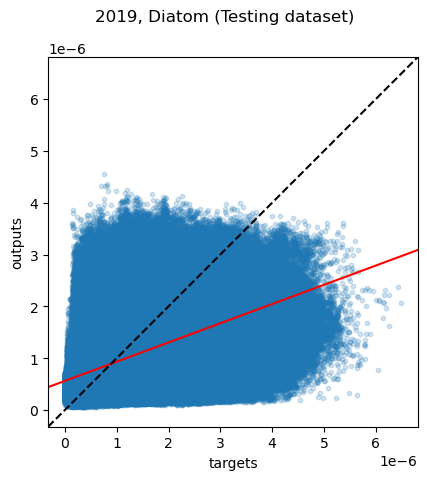

Gathering days for year 2020


100%|██████████| 76/76 [02:44<00:00,  2.16s/it]


The amount of data points is 3532404
The slope of the best fitting line is  0.312
The correlation coefficient is: 0.36
 The mean square error is: 0.0


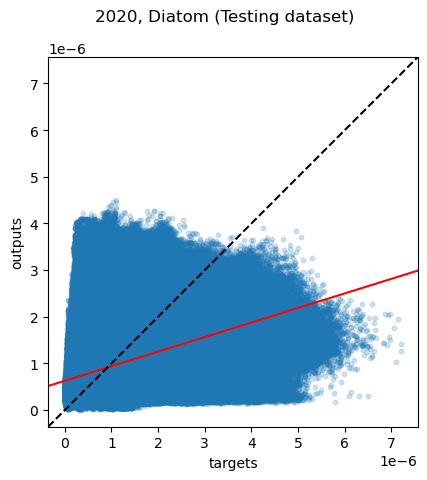

Gathering days for year 2021


100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.533
The correlation coefficient is: 0.594
 The mean square error is: 0.0


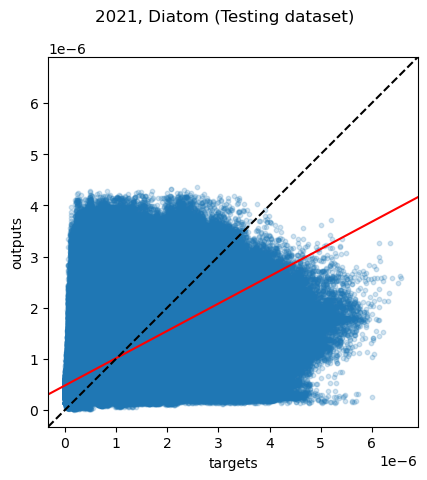

Gathering days for year 2022


100%|██████████| 75/75 [02:54<00:00,  2.32s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.624
The correlation coefficient is: 0.611
 The mean square error is: 0.0


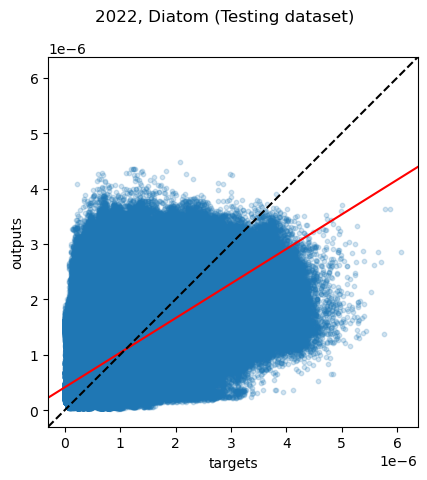

Gathering days for year 2023


100%|██████████| 75/75 [03:00<00:00,  2.41s/it]


The amount of data points is 3485925
The slope of the best fitting line is  0.473
The correlation coefficient is: 0.53
 The mean square error is: 0.0


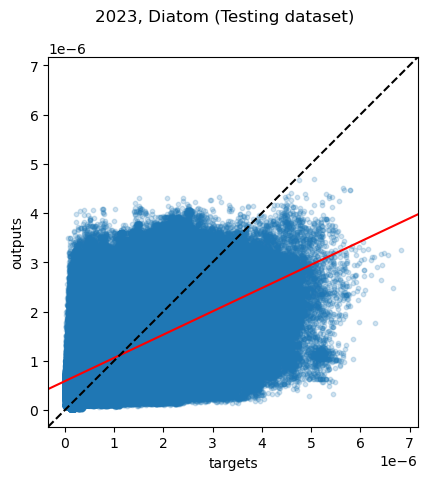

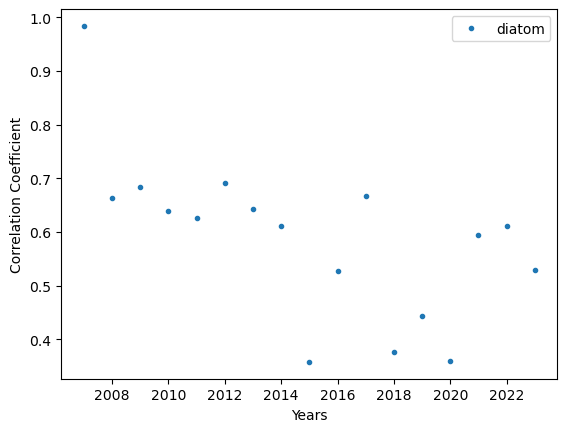

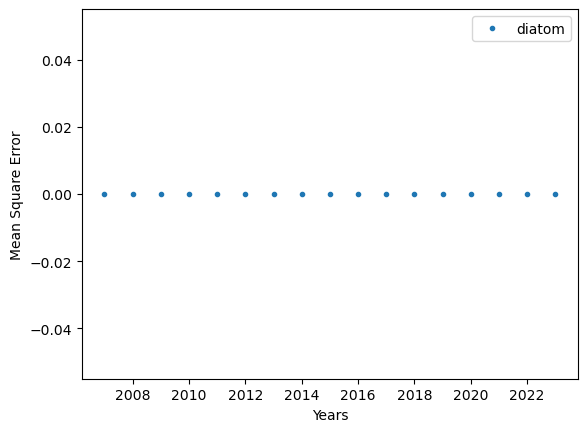

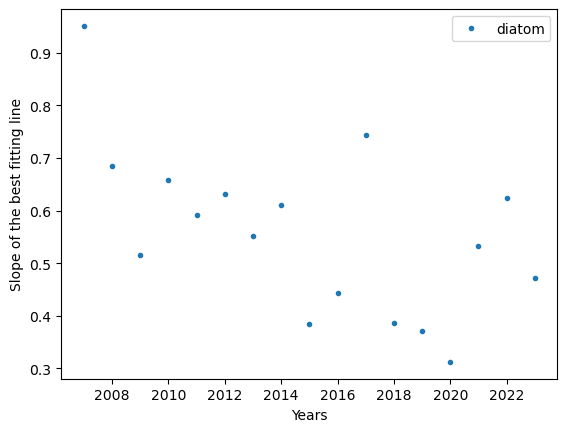

In [41]:
years = range (2007,2024)

r_all = []
rms_all = []
slope_all = []

for year in range (2007,2024):

    year_str = str(year)[2:4]

    folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
    indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
    folders = [folders[i] for i in indx_dates]

    drivers_all = np.array([[],[],[],[]])
    diat_all = np.array([])

    print ('Gathering days for year ' + str(year))
    
    for i in tqdm(folders):

        temp_i1, temp_i2, saline_i1, saline_i2, diat_i = datasets_preparation()

        drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
        indx = np.where(~np.isnan(drivers).any(axis=0))
        drivers = drivers[:,indx[0]]
        drivers_all = np.concatenate((drivers_all,drivers),axis=1)

        diat = np.ravel(diat_i)
        diat = diat[indx[0]]
        diat_all = np.concatenate((diat_all,diat))

    r, rms, m = regressor2(drivers_all, diat_all, 'Diatom')
    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)
    
plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')
